**File Contents:**
1. **Data Preparation**\
    1.1.  **Sample Dataset Preparation**\
        1.1.1. Data Encoding\
        1.1.2. Merge with Target\
    1.2.  **Feature Engeneering**\
    1.3.  **Full Dataset Preparation**\
        1.3.1. Data Encoding\
        1.3.2. Merge with Target\
2. **Modeling**\
    2.1. **Random Forest Classifier**\
        2.1.1. Hyperparameter Selection\
        2.1.2. Best Random Forest Classifier\
    2.2. **Gradient Boosting Classifier**\
        2.2.1. Hyperparameter Selection\
        2.2.2. Best Gradient Boosting Classifier\
    2.3. **MLP Classifier**\
        2.3.1. Hyperparameter Selection\
        2.3.2. Best MLP Classifier\
    2.4. **Cat Boost Classifier**\
        2.4.1. Hyperparameter Selection\
        2.4.2. Best Cat Boost Classifier\
    2.5. **Best Model**
3. **PipeLine**
4. **Result**

In [1]:
import os
import time
import gc
import datetime
import tqdm
import dill

import pandas as pd
import numpy as np

import optuna
from catboost import CatBoostClassifier

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

# 1. Data Preparation

**Data description:** \
**id** - Application identifier. Applications are numbered so that a higher number corresponds to a later application date;\
**rn** - Sequence number of the credit product in the credit history. The higher the number, the product with the later opening date corresponds to;\
**pre_since_opened** - Days from the loan opening date to the data collection date (binarized(a));\
**pre_since_confirmed** - Days from the loan information confirmation date to the data collection date (binarized(a));\
**pre_pterm** - Planned number of days from the loan opening date to the closing date (binarized(a));\
**pre_fterm** - Actual number of days from the loan opening date to the closing date (binarized(a));\
**pre_till_pclose** - Planned number of days from the data collection date to the loan closing date (binarized(a));\
**pre_till_fclose** - Actual number of days from the data collection date to the loan closing date (binarized(a));\
**pre_loans_credit_limit** - Credit limit (binarized(a));\
**pre_loans_next_pay_summ** - Next loan payment amount (binarized(a));\
**pre_loans_outstanding** - Remaining outstanding loan amount (binarized(a));\
**pre_loans_total_overdue** - Current overdue amount (binarized(a));\
**pre_loans_max_overdue_sum** - Maximum overdue amount (binarized(a));\
**pre_loans_credit_cost_rate** - Total cost of loan (binarized(a));\
**pre_loans5** - Number of overdue payments up to 5 days (binarized(a));\
**pre_loans530** - Number of overdue payments from 5 to 30 days (binarized(a));\
**pre_loans3060** - Number of overdue payments from 30 to 60 days (binarized(a));\
**pre_loans6090** - Number of overdue payments from 60 to 90 days (binarized(a));\
**pre_loans90** - Number of overdue payments more than 90 days (binarized(a));\
**is_zero_loans_5** - Flag: no overdue payments up to 5 days;\
**is_zero_loans_530** - Flag: no overdue payments from 5 to 30 days;\
**is_zero_loans_3060** - Flag: no overdue payments from 30 to 60 days;\
**is_zero_loans_6090** - Flag: no overdue payments from 60 to 90 days;\
**is_zero_loans90** - Flag: no overdue payments more than 90 days;\
**pre_util** - Ratio of the remaining unpaid loan amount to the credit limit (binarized(a));\
**pre_over2limit** - Ratio of the current overdue debt to the credit limit (binarized(a));\
**pre_maxover2limit** - Ratio of the maximum overdue debt to the credit limit (binarized(a));\
**is_zero_util** - Flag: the ratio of the remaining unpaid loan amount to the credit limit is 0;\
**is_zero_over2limit** - Flag: the ratio of the current overdue debt to the credit limit is 0;\
**is_zero_maxover2limit** - Flag: the ratio of the maximum overdue debt to the credit limit is 0;\
**enc_paym_{0..N}** - Monthly payment statuses for the last N months (coded(b));\
**enc_loans_account_holder_type** - Loan relationship type (coded(b));\
**enc_loans_credit_status** - Loan status (coded(b));\
**enc_loans_account_cur** - Loan currency (coded(b));\
**enc_loans_credit_type** - Loan type (coded(b));\
**pclose_flag** - Flag: planned number of days from loan opening date to closing date is not defined;\
**fclose_flag** - Flag: actual number of days from loan opening date to closing date is not defined.

**(a)** - The range of field values ​​is divided into N non-intersecting intervals, each interval is randomly assigned a unique number from 0 to N-1, the field value is replaced by the number of the interval to which it belongs.\
**(b)** - Each unique field value is randomly assigned a unique number from 0 to K, the field value is replaced by the number of this value.

**Target Description:**\
**id** - Application identifier. Applications are numbered so that later applications correspond to a later date;\
**flag** - Target variable, 1 – fact of default. Available to participants in the training sample.

In [2]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    reading num_parts_to_read parquets, transform them to pd.DataFrame and return
    :param path_to_dataset: path to parquets
    :param start_from: the start parquet number
    :param num_parts_to_read: amount of parquets to read
    :param columns: column list to read from parquet
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [3]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    return a prepared pd.DataFrame with features
    path_to_dataset: str
        path to parquets
    num_parts_to_preprocess_at_once: int
        amount of parquets to processing simultaneously (in RAM)
    num_parts_total: int
        total amount of parquets to process
    save_to_path: str
        path to the folder where each processed block will be saved in .parquet format; if None, it will not be saved
    verbose: bool
        logs each processed piece of data
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)

        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
        
    return pd.concat(preprocessed_frames)

## 1.1. Sample Dataset Preparation

**Done:**\
**1) Loading a trial dataset.**\
**2) Checking for missing values - no missing values.**\
**3) Encoding categorical features using OneHotEncoder.**\
**4) Merging with the target variable.**

In [4]:
path = './data/train_data'
df = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=2, num_parts_total=2) # total_full = 12
                                   
print('Shape:', df.shape)
df.head()

Transforming transactions data:   0%|          | 0/1 [00:00<?, ?it/s]

['C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_0.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_1.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_10.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_11.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_2.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_3.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_4.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_5.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Jun

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\train_data_0.pq
chunk_path C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\train_data_1.pq
Shape: (4082029, 61)


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [5]:
missing_values = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
missing_values

id                    0.0
enc_paym_1            0.0
enc_paym_3            0.0
enc_paym_4            0.0
enc_paym_5            0.0
                     ... 
pre_over2limit        0.0
pre_maxover2limit     0.0
is_zero_util          0.0
is_zero_over2limit    0.0
fclose_flag           0.0
Length: 61, dtype: float64

In [6]:
df.to_csv('./data/initial_data_short.csv',
          index=False)

### 1.1.1. Data Encoding

In [7]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
columns = df.columns[1:]

for i in range(0, len(columns), 2):
    df[ohe.get_feature_names_out()] = ohe.fit_transform(df[[columns[i], columns[i+1]]])
    df = df.drop(columns=[columns[i], columns[i+1]])
    
df.shape

(4082029, 452)

In [9]:
df = df.groupby('id')[df.columns[1:]].sum()
df.shape

(500000, 451)

### 1.1.2. Merge with Target

In [10]:
df_target = pd.read_csv('./data/train_target.csv')
df_target.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [11]:
df = pd.merge(left=df, right=df_target, on='id', how='inner')

print('Shape:', df.shape)
df.head()

Shape: (500000, 453)


,id,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,...,enc_loans_credit_type_5,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pclose_flag_0,pclose_flag_1,fclose_flag_0,fclose_flag_1,flag
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,10.0,0.0,0.0,9.0,1.0,8.0,2.0,0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,14.0,0.0,0.0,13.0,1.0,12.0,2.0,0
2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,1.0,2.0,1.0,2.0,0
3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,15.0,0.0,0.0,10.0,5.0,9.0,6.0,0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0


In [12]:
df.to_csv('./data/prepared_data_short.csv',
          index=False)

## 1.2. Feature Engeneering

**The analysis of the influence of features on the quality metric (ROC-AUC) was performed.\
Based on the analysis results, all features from the original dataset were selected.**

In [13]:
df['flag'].value_counts()

0    484054
1     15946
Name: flag, dtype: int64

In [14]:
y = df['flag']
X = df.drop(columns=['flag', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

In [15]:
mm_scaler = MinMaxScaler()
columns = X_train.columns

X_train[columns] = mm_scaler.fit_transform(X_train[columns])
X_test[columns] = mm_scaler.transform(X_test[columns])

In [16]:
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)

pred_logreg_train = logreg.predict(X_train)
pred_logreg_test = logreg.predict(X_test)

print(
    f'ROC-AUC train_set for LogisticRegression: {roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1])}\n'
    f'ROC-AUC test_set for LogisticRegression: {roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])}\n\n'
    f'Precision train_set for LogisticRegression: {precision_score(y_train, pred_logreg_train)}\n'
    f'Precision test_set for LogisticRegression: {precision_score(y_test, pred_logreg_test)}\n\n'
    f'Recall train_set for LogisticRegression: {recall_score(y_train, pred_logreg_train)}\n'
    f'Recall test_set for LogisticRegression: {recall_score(y_test, pred_logreg_test)}\n'
    )
print('Confusion_matrix test_set for LogisticRegression:')
confusion_matrix(y_test, pred_logreg_test)

ROC-AUC train_set for LogisticRegression: 0.7621582652850412
ROC-AUC test_set for LogisticRegression: 0.7533968752705333

Precision train_set for LogisticRegression: 0.06852140739481136
Precision test_set for LogisticRegression: 0.0669379570653456

Recall train_set for LogisticRegression: 0.7265030963392647
Recall test_set for LogisticRegression: 0.7118218877391032

Confusion_matrix test_set for LogisticRegression:


array([[65169, 31642],
       [  919,  2270]], dtype=int64)

In [17]:
# Features selection
list_columns = list(set(['_'.join(col.split('_')[:-1]) for col in x_train.columns])) # get columns list before OHE

for col in list_columns:
    new_list_columns = [i for i in x_train.columns if col+'_' not in i] # remove all columns based on initial column
    X_train_short = X_train[new_list_columns]
    X_test_short = X_test[new_list_columns]
    
    logreg = LogisticRegression(class_weight='balanced', random_state=42)
    logreg.fit(X_train_short, y_train)
    
    print(
        f'REMOVED column: {col}\n'
        f'ROC-AUC train_set: {roc_auc_score(y_train, logreg.predict_proba(X_train_short)[:,1])}\n'
        f'ROC-AUC test_set: {roc_auc_score(y_test, logreg.predict_proba(X_test_short)[:,1])}\n'
    )

REMOVED column: pre_loans6090
ROC-AUC train_set: 0.7620177017802554
ROC-AUC test_set: 0.7535343998442083

REMOVED column: is_zero_loans530
ROC-AUC train_set: 0.7607013792293509
ROC-AUC test_set: 0.7523804897024695

REMOVED column: enc_paym_11
ROC-AUC train_set: 0.7616890459856377
ROC-AUC test_set: 0.7530849104049169

REMOVED column: is_zero_over2limit
ROC-AUC train_set: 0.7618330274658296
ROC-AUC test_set: 0.7533081959220463

REMOVED column: rn
ROC-AUC train_set: 0.7613660304071137
ROC-AUC test_set: 0.7521526824390297

REMOVED column: enc_paym_10
ROC-AUC train_set: 0.7620641684322281
ROC-AUC test_set: 0.7534172328461506

REMOVED column: enc_paym_9
ROC-AUC train_set: 0.7614079621941743
ROC-AUC test_set: 0.753519250698439

REMOVED column: pre_since_confirmed
ROC-AUC train_set: 0.7609422991276364
ROC-AUC test_set: 0.7534744915642045

REMOVED column: pre_over2limit
ROC-AUC train_set: 0.7616452187758518
ROC-AUC test_set: 0.7529387342664889

REMOVED column: pre_loans_outstanding
ROC-AUC trai

## 1.3. Full Dataset Preparation

**Done:**\
**1) Loading the full dataset.**\
**2) Checking for missing values - no missing values.**\
**3) Encoding categorical attributes using OneHotEncoder.**\
**4) Merging with the target variable.**

In [18]:
# loading the full dataset
path = './data/train_data'
df_full = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=12, num_parts_total=12)

print('Shape:', df_full.shape)
df_full.head()

Transforming transactions data:   0%|          | 0/1 [00:00<?, ?it/s]

['C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_0.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_1.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_10.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_11.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_2.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_3.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_4.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\\train_data_5.pq', 'C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Jun

Reading dataset with pandas:   0%|          | 0/12 [00:00<?, ?it/s]

chunk_path C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\train_data_0.pq
chunk_path C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\train_data_1.pq
chunk_path C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\train_data_10.pq
chunk_path C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\train_data_11.pq
chunk_path C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\train_data_2.pq
chunk_path C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\train_data_3.pq
chunk_path C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\train_data_4.pq
chunk_path C:/Users/user/Desktop/Data_Science/Homework/Core_courses/Junior_courses/FInal_project/train_data\train_data_5.pq
chunk_

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [19]:
# checking missed values
missing_values = (df_full.isna().sum() / len(df_full) * 100).sort_values(ascending=False)
missing_values

id                    0.0
enc_paym_1            0.0
enc_paym_3            0.0
enc_paym_4            0.0
enc_paym_5            0.0
                     ... 
pre_over2limit        0.0
pre_maxover2limit     0.0
is_zero_util          0.0
is_zero_over2limit    0.0
fclose_flag           0.0
Length: 61, dtype: float64

In [20]:
# saving the initial dataset
df_full.to_csv('./data/initial_data.csv', index=False)

### 1.3.1. Data Encoding

In [21]:
# saving the initial dataset in split form by 2 columns + id column
path_folder = './data/data_columns'
columns = df_full.columns[1:]

for i in range(0, len(columns), 2):
    df_full[['id', columns[i], columns[i+1]]].to_csv(f'{path_folder}/id_columns_{i+1}-{i+2}.csv', index=False)

In [22]:
# reading splited datasets and encoding them with OHE encoder, then agregate and save splited prepared datasets
path_folder = './data/data_columns'

for i in range(1, 60, 2):
    df = pd.read_csv(f'{path_folder}/id_columns_{i}-{i+1}.csv')
    
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    df_new = pd.concat(
            [df['id'], pd.DataFrame(ohe.fit_transform(df[df.columns[1:]]), columns=ohe.get_feature_names_out())], axis=1
    )
    
    df_new = df_new.groupby('id')[df_new.columns[1:]].sum()
    df_new.to_csv(f'{path_folder}/id_columns_{i}-{i+1}_prepared.csv')

In [24]:
# merging splited prepared datasets
path_folder = './data/data_columns'
df_full = pd.read_csv(f'{path_folder}/id_columns_{1}-{1+1}_prepared.csv')

for i in range(3, 60, 2):
    df = pd.read_csv(f'{path_folder}/id_columns_{i}-{i+1}_prepared.csv')
    df_full = pd.merge(left=df_full, right=df, on='id', how='inner')
    
print('Shape', df_full.shape)
df_full.head()

Shape (3000000, 478)


,id,rn_1,rn_2,rn_3,rn_4,rn_5,rn_6,rn_7,rn_8,rn_9,...,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pclose_flag_0,pclose_flag_1,fclose_flag_0,fclose_flag_1
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,10.0,0.0,0.0,9.0,1.0,8.0,2.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,14.0,0.0,0.0,13.0,1.0,12.0,2.0
2,2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0,1.0,2.0
3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,15.0,0.0,0.0,10.0,5.0,9.0,6.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


### 1.3.2. Merge with Target

In [25]:
# reading the target dataset
df_target = pd.read_csv('./data/train_target.csv')
df_target.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [26]:
# merging the prepared dataset with target
df_full = pd.merge(left=df_full, right=df_target, on='id', how='inner')
df_full.shape

(3000000, 479)

In [27]:
# saving the final dataset
df_full.to_csv('./data/prepared_data.csv', index=False)

# 2. Modeling

**Done:**\
**1) The dataset was divided into training and testing 80/20, respectively.**\
**2) Standardization of numerical features using the MinMaxScale method.**\
**3) Based on the analysis of the initial data, four models were selected: RandomForestClassifier, GradientBoostingClassifier, MLPClassifier, and CatBoostClassifier.**\
**4) Selection of hyperparameters on a reduced dataset for each model.**\
**5) Models with the best hyperparameters were trained on the full training dataset.**

In [28]:
df_train, df_test = train_test_split(df_full, stratify=df_full['flag'], test_size=.2, random_state=42)

print('Shape of the train dataset:', df_train.shape)
print('Shape of the test dataset:', df_test.shape)

Shape of the train dataset: (2400000, 479)
Shape of the test dataset: (600000, 479)


In [29]:
y_train = df_train['flag']
X_train = df_train.drop(columns=['flag', 'id'])

y_test = df_test['flag']
X_test = df_test.drop(columns=['flag', 'id'])

In [31]:
mm_scaler = MinMaxScaler()
columns = X_train.columns

X_train[columns] = mm_scaler.fit_transform(X_train[columns])
X_test[columns] = mm_scaler.transform(X_test[columns])

## 2.1. Random Forest Classifier

In [33]:
rfc = RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-2, random_state=42)
rfc.fit(X_train, y_train)

pred_rfc_train = rfc.predict(X_train)
pred_rfc_test = rfc.predict(X_test)

print(
    f'ROC-AUC train_set for RandomForestClassifier: {roc_auc_score(y_train, rfc.predict_proba(X_train)[:, 1])}\n'
    f'ROC-AUC test_set for RandomForestClassifier: {roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])}\n\n'
    f'Precision train_set for RandomForestClassifier: {precision_score(y_train, pred_rfc_train)}\n'
    f'Precision test_set for RandomForestClassifier: {precision_score(y_test, pred_rfc_test)}\n\n'
    f'Recall train_set for RandomForestClassifier: {recall_score(y_train, pred_rfc_train)}\n'
    f'Recall test_set for RandomForestClassifier: {recall_score(y_test, pred_rfc_test)}\n\n'
    f'Confusion_matrix test_set for RandomForestClassifier:\n {confusion_matrix(y_test, pred_rfc_test)}'
    )

ROC-AUC train_set for RandomForestClassifier: 0.9988047202597948
ROC-AUC test_set for RandomForestClassifier: 0.7059097466934293

Precision train_set for RandomForestClassifier: 0.9371228085660381
Precision test_set for RandomForestClassifier: 0.1527313266443701

Recall train_set for RandomForestClassifier: 0.9974634192169481
Recall test_set for RandomForestClassifier: 0.012871101089815859

Confusion_matrix test_set for RandomForestClassifier:
 [[577192   1520]
 [ 21014    274]]


### 2.1.1. Hyperparameter Selection

In [36]:
# Reduce the dataset so that  to speed up hyperparameter selection 
df_short = df_full.sample(150000)
df_short['flag'].value_counts()

0    144713
1      5287
Name: flag, dtype: int64

In [39]:
X_short = df_short.drop(columns=['flag', 'id'])
y_short = df_short['flag']

X_train_short, X_test_short, y_train_short, y_test_short = train_test_split(X_short, y_short, test_size=.3,
                                                                            stratify=y_short, random_state=42)

In [40]:
mm_scaler = MinMaxScaler()
columns = X_train_short.columns

X_train_short[columns] = mm_scaler.fit_transform(X_train_short[columns])
X_test_short[columns] = mm_scaler.transform(X_test_short[columns])

In [41]:
rfc = RandomForestClassifier(n_jobs=-2, random_state=42)
rfc.fit(X_train_short, y_train_short)

pred_rfc_train = rfc.predict(X_train_short)
pred_rfc_test = rfc.predict(X_test_short)

print(
    f'ROC-AUC train for RandomForestClassifier: {roc_auc_score(y_train_short, rfc.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test for RandomForestClassifier: {roc_auc_score(y_test_short, rfc.predict_proba(X_test_short)[:, 1])}\n\n'
    f'Precision train_set for RandomForestClassifier: {precision_score(y_train_short, pred_rfc_train)}\n'
    f'Precision test_set for RandomForestClassifier: {precision_score(y_test_short, pred_rfc_test)}\n\n'
    f'Recall train_set for RandomForestClassifier: {recall_score(y_train_short, pred_rfc_train)}\n'
    f'Recall test_set for RandomForestClassifier: {recall_score(y_test_short, pred_rfc_test)}\n\n'
    f'Recall train_set for RandomForestClassifier: {recall_score(y_train_short, pred_rfc_train)}\n'
    f'Confusion_matrix test_set for RandomForestClassifier:\n {confusion_matrix(y_test_short, pred_rfc_test)}'
    )

ROC-AUC train for RandomForestClassifier: 0.9999953761940151
ROC-AUC test for RandomForestClassifier: 0.6887118325449959

Precision train_set for RandomForestClassifier: 0.9991845610220168
Precision test_set for RandomForestClassifier: 0.1111111111111111

Recall train_set for RandomForestClassifier: 0.9932450689002972
Recall test_set for RandomForestClassifier: 0.0012610340479192938

Recall train_set for RandomForestClassifier: 0.9932450689002972
Confusion_matrix test_set for RandomForestClassifier:
 [[43398    16]
 [ 1584     2]]


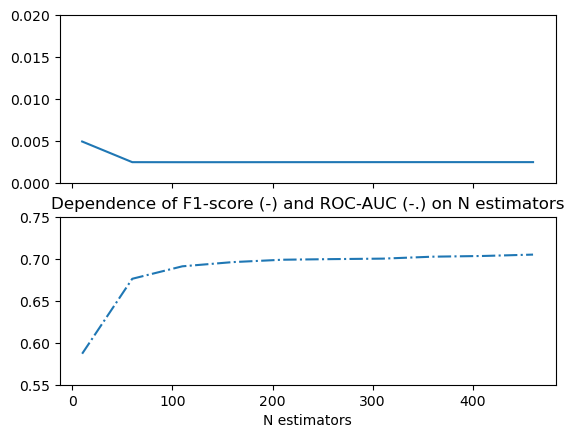

In [42]:
N = []
f1 = []
roc_auc = []

for n in range(10, 510, 50):
    rfc = RandomForestClassifier(n_estimators = n, random_state=42, n_jobs=-2)
    rfc.fit(X_train_short, y_train_short)

    N.append(n)
    f1.append(f1_score(y_test_short, rfc.predict(X_test_short)))
    roc_auc.append(roc_auc_score(y_test_short, rfc.predict_proba(X_test_short)[:, 1]))
    
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(N, f1, '-')
ax[0].set_ylim(0.0, 0.02)
ax[1].plot(N, roc_auc, '-.')
ax[1].set_ylim(0.55, 0.75)
plt.xlabel('N estimators')
plt.title('Dependence of F1-score (-) and ROC-AUC (-.) on N estimators')
plt.show();

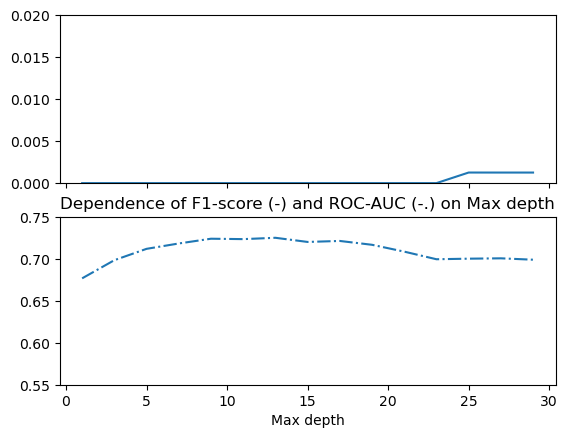

In [44]:
depths = []
f1 = []
roc_auc = []

for depth in range(1, 30, 2):
    rfc = RandomForestClassifier(n_estimators = 100, max_depth=depth, random_state=42, n_jobs=-2)
    rfc.fit(X_train_short, y_train_short)

    depths.append(depth)
    f1.append(f1_score(y_test_short, rfc.predict(X_test_short)))
    roc_auc.append(roc_auc_score(y_test_short, rfc.predict_proba(X_test_short)[:, 1]))

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(depths, f1, '-')
ax[0].set_ylim(0.0, 0.02)
ax[1].plot(depths, roc_auc, '-.')
ax[1].set_ylim(0.55, 0.75)
plt.xlabel('Max depth')
plt.title('Dependence of F1-score (-) and ROC-AUC (-.) on Max depth')
plt.show();

In [45]:
parameters_rfc = {
                  'n_estimators': [100, 400],
                  'criterion': ['gini', 'log_loss'],
                  'max_depth': [15, 25],
                  'max_features': ['sqrt', 'log2'],
                  'min_samples_split': [2, 50, 100],
                  'class_weight': ['balanced_subsample']
}

scores = ['f1', 'roc_auc']
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

list_params = []

for score in scores:
    grid = GridSearchCV(RandomForestClassifier(random_state=42), parameters_rfc, scoring=score, cv=cv, n_jobs=-2)
    grid.fit(X_train_short, y_train_short)
    
    list_params.append((score, grid.best_params_))
    print(score, grid.best_params_)

f1 {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 100, 'n_estimators': 400}
roc_auc {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_split': 100, 'n_estimators': 400}


In [46]:
# F1
rfc1 = RandomForestClassifier(n_estimators=400, class_weight='balanced_subsample', criterion='log_loss', max_depth=15,
                              max_features='log2', min_samples_split=100, n_jobs=-2, random_state=42)
rfc1.fit(X_train_short, y_train_short)

pred_rfc_train1 = rfc1.predict(X_train_short)
pred_rfc_test1 = rfc1.predict(X_test_short)

print(
    f'ROC-AUC train for RandomForestClassifier: {roc_auc_score(y_train_short, rfc1.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test for RandomForestClassifier: {roc_auc_score(y_test_short, rfc1.predict_proba(X_test_short)[:, 1])}\n\n'
    f'Precision train_set for RandomForestClassifier: {precision_score(y_train_short, pred_rfc_train1)}\n'
    f'Precision test_set for RandomForestClassifier: {precision_score(y_test_short, pred_rfc_test1)}\n\n'
    f'Recall train_set for RandomForestClassifier: {recall_score(y_train_short, pred_rfc_train1)}\n'
    f'Recall test_set for RandomForestClassifier: {recall_score(y_test_short, pred_rfc_test1)}\n\n'
    f'Confusion_matrix test_set for RandomForestClassifier:\n {confusion_matrix(y_test_short, pred_rfc_test1)}'
    )

ROC-AUC train for RandomForestClassifier: 0.9190264145592846
ROC-AUC test for RandomForestClassifier: 0.7135448052246441

Precision train_set for RandomForestClassifier: 0.21626106194690264
Precision test_set for RandomForestClassifier: 0.09351403678606002

Recall train_set for RandomForestClassifier: 0.7395298567954607
Recall test_set for RandomForestClassifier: 0.30453972257250944

Confusion_matrix test_set for RandomForestClassifier:
 [[38732  4682]
 [ 1103   483]]


In [47]:
# ROC AUC
rfc2 = RandomForestClassifier(n_estimators=400, class_weight='balanced_subsample', criterion='log_loss', max_depth=25,
                              max_features='sqrt', min_samples_split=100, n_jobs=-2, random_state=42)
rfc2.fit(X_train_short, y_train_short)

pred_rfc_train2 = rfc2.predict(X_train_short)
pred_rfc_test2 = rfc2.predict(X_test_short)

print(
    f'ROC-AUC train for RandomForestClassifier: {roc_auc_score(y_train_short, rfc2.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test for RandomForestClassifier: {roc_auc_score(y_test_short, rfc2.predict_proba(X_test_short)[:, 1])}\n\n'
    f'Precision train_set for RandomForestClassifier: {precision_score(y_train_short, pred_rfc_train2)}\n'
    f'Precision test_set for RandomForestClassifier: {precision_score(y_test_short, pred_rfc_test2)}\n\n'
    f'Recall train_set for RandomForestClassifier: {recall_score(y_train_short, pred_rfc_train2)}\n'
    f'Recall test_set for RandomForestClassifier: {recall_score(y_test_short, pred_rfc_test2)}\n\n'
    f'Confusion_matrix test_set for RandomForestClassifier:\n {confusion_matrix(y_test_short, pred_rfc_test2)}'
    )

ROC-AUC train for RandomForestClassifier: 0.9864824065622634
ROC-AUC test for RandomForestClassifier: 0.7310442305354048

Precision train_set for RandomForestClassifier: 0.5336359215431998
Precision test_set for RandomForestClassifier: 0.1386530843237125

Recall train_set for RandomForestClassifier: 0.8894893272088624
Recall test_set for RandomForestClassifier: 0.1544766708701135

Confusion_matrix test_set for RandomForestClassifier:
 [[41892  1522]
 [ 1341   245]]


### 2.1.2. Best Random Forest Classifier

In [48]:
rfc_best = RandomForestClassifier(n_estimators=400, class_weight='balanced_subsample', criterion='log_loss', max_depth=15,
                                  max_features='log2', min_samples_split=100, n_jobs=-2, random_state=42)
rfc_best.fit(X_train, y_train)

pred_rfc_best_train = rfc_best.predict(X_train)
pred_rfc_best_test = rfc_best.predict(X_test)

print(
    f'ROC-AUC train_set for RandomForestClassifier: {roc_auc_score(y_train, rfc_best.predict_proba(X_train)[:, 1])}\n'
    f'ROC-AUC test_set for RandomForestClassifier: {roc_auc_score(y_test, rfc_best.predict_proba(X_test)[:, 1])}\n\n'
    f'Precision train_set for RandomForestClassifier: {precision_score(y_train, pred_rfc_best_train)}\n'
    f'Precision test_set for RandomForestClassifier: {precision_score(y_test, pred_rfc_best_test)}\n\n'
    f'Recall train_set for RandomForestClassifier: {recall_score(y_train, pred_rfc_best_train)}\n'
    f'Recall test_set for RandomForestClassifier: {recall_score(y_test, pred_rfc_best_test)}\n\n'
    f'Confusion_matrix test_set for RandomForestClassifier:\n {confusion_matrix(y_test, pred_rfc_best_test)}'
    )

ROC-AUC train_set for RandomForestClassifier: 0.7952642747820704
ROC-AUC test_set for RandomForestClassifier: 0.7278504232184072

Precision train_set for RandomForestClassifier: 0.09241225046150522
Precision test_set for RandomForestClassifier: 0.07606968020853201

Recall train_set for RandomForestClassifier: 0.6831152969913333
Recall test_set for RandomForestClassifier: 0.562053739195791

Confusion_matrix test_set for RandomForestClassifier:
 [[433387 145325]
 [  9323  11965]]


## 2.2. Gradient Boosting Classifier

In [54]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

pred_gbc_train = gbc.predict(X_train)
pred_gbc_test = gbc.predict(X_test)

print(
    f'ROC-AUC train_set for GradientBoostingClassifier: {roc_auc_score(y_train, gbc.predict_proba(X_train)[:, 1])}\n'
    f'ROC-AUC test_set for GradientBoostingClassifier: {roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])}\n\n'
    f'Precision train_set for GradientBoostingClassifier: {precision_score(y_train, pred_gbc_train)}\n'
    f'Precision test_set for GradientBoostingClassifier: {precision_score(y_test, pred_gbc_test)}\n\n'
    f'Recall train_set for GradientBoostingClassifier: {recall_score(y_train, pred_gbc_train)}\n'
    f'Recall test_set for GradientBoostingClassifier: {recall_score(y_test, pred_gbc_test)}\n\n'
    f'Confusion_matrix test_set for GradientBoostingClassifier:\n {confusion_matrix(y_test, pred_gbc_test)}'
    )

ROC-AUC train_set for GradientBoostingClassifier: 0.7485434603014609
ROC-AUC test_set for GradientBoostingClassifier: 0.7452088822593084

Precision train_set for GradientBoostingClassifier: 0.5631067961165048
Precision test_set for GradientBoostingClassifier: 0.3953488372093023

Recall train_set for GradientBoostingClassifier: 0.0006811189139676351
Recall test_set for GradientBoostingClassifier: 0.0007985719654265313

Confusion_matrix test_set for GradientBoostingClassifier:
 [[578686     26]
 [ 21271     17]]


### 2.2.1. Hyperparameter Selection

**Reduce the dataset so that to speed up hyperparameter selection.**

In [55]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_short, y_train_short)

pred_gbc_train = gbc.predict(X_train_short)
pred_gbc_test = gbc.predict(X_test_short)

print(
    f'ROC-AUC train_set for GBC: {roc_auc_score(y_train_short, gbc.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test_set for GBC: {roc_auc_score(y_test_short, gbc.predict_proba(X_test_short)[:, 1])}\n\n'
    f'Precision train_set for GBC: {precision_score(y_train_short, pred_gbc_train)}\n'
    f'Precision test_set for GBC: {precision_score(y_test_short, pred_gbc_test)}\n\n'
    f'Recall train_set for GBC: {recall_score(y_train_short, pred_gbc_train)}\n'
    f'Recall test_set for GBC: {recall_score(y_test_short, pred_gbc_test)}\n\n'
    f'Confusion_matrix test_set for GBC:\n {confusion_matrix(y_test_short, pred_gbc_test)}'
    )

ROC-AUC train_set for GBC: 0.770562220585985
ROC-AUC test_set for GBC: 0.741394344523425

Precision train_set for GBC: 0.9591836734693877
Precision test_set for GBC: 0.18518518518518517

Recall train_set for GBC: 0.012699270467441232
Recall test_set for GBC: 0.0031525851197982345

Confusion_matrix test_set for GBC:
 [[43392    22]
 [ 1581     5]]


In [56]:
parameters_gbc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 10, 20],
    'max_features': ['sqrt', 'log2']
}

scores = ['f1', 'roc_auc']
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

list_params = []

for score in scores:
    grid = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters_gbc, scoring=score, cv=cv, n_jobs=-2)
    grid.fit(X_train_short, y_train_short)
    
    list_params.append((score, grid.best_params_))
    print(score, grid.best_params_)

f1 {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}
roc_auc {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}


In [60]:
# F1
gbc1 = GradientBoostingClassifier(n_estimators=50, max_depth=10, max_features='sqrt', min_samples_split=2,
                                  random_state=42)
gbc1.fit(X_train_short, y_train_short)

pred_gbc_train1 = gbc1.predict(X_train_short)
pred_gbc_test1 = gbc1.predict(X_test_short)

print(
    f'ROC-AUC train_set for GBC: {roc_auc_score(y_train_short, gbc1.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test_set for GBC: {roc_auc_score(y_test_short, gbc1.predict_proba(X_test_short)[:, 1])}\n\n'
    f'Precision train_set for GBC: {precision_score(y_train_short, pred_gbc_train1)}\n'
    f'Precision test_set for GBC: {precision_score(y_test_short, pred_gbc_test1)}\n\n'
    f'Recall train_set for GBC: {recall_score(y_train_short, pred_gbc_train1)}\n'
    f'Recall test_set for GBC: {recall_score(y_test_short, pred_gbc_test1)}\n\n'
    f'Confusion_matrix test_set for GBC:\n {confusion_matrix(y_test_short, pred_gbc_test1)}'
    )

ROC-AUC train_set for GBC: 0.9472655380879597
ROC-AUC test_set for GBC: 0.7265623588511234

Precision train_set for GBC: 0.9991582491582491
Precision test_set for GBC: 0.08080808080808081

Recall train_set for GBC: 0.32072412861388816
Recall test_set for GBC: 0.01008827238335435

Confusion_matrix test_set for GBC:
 [[43232   182]
 [ 1570    16]]


In [61]:
# ROC-AUC
gbc2 = GradientBoostingClassifier(n_estimators=100, max_depth=5, max_features='sqrt', min_samples_split=20,
                                  random_state=42)
gbc2.fit(X_train_short, y_train_short)

pred_gbc_train2 = gbc2.predict(X_train_short)
pred_gbc_test2 = gbc2.predict(X_test_short)

print(
    f'ROC-AUC train_set for GBC: {roc_auc_score(y_train_short, gbc2.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test_set for GBC: {roc_auc_score(y_test_short, gbc2.predict_proba(X_test_short)[:, 1])}\n\n'
    f'Precision train_set for GBC: {precision_score(y_train_short, pred_gbc_train2)}\n'
    f'Precision test_set for GBC: {precision_score(y_test_short, pred_gbc_test2)}\n\n'
    f'Recall train_set for GBC: {recall_score(y_train_short, pred_gbc_train2)}\n'
    f'Recall test_set for GBC: {recall_score(y_test_short, pred_gbc_test2)}\n\n'
    f'Confusion_matrix test_set for GBC:\n {confusion_matrix(y_test_short, pred_gbc_test2)}'
    )

ROC-AUC train_set for GBC: 0.8058443235235677
ROC-AUC test_set for GBC: 0.7418299653571458

Precision train_set for GBC: 0.9838709677419355
Precision test_set for GBC: 0.17647058823529413

Recall train_set for GBC: 0.03296406376654958
Recall test_set for GBC: 0.0037831021437578815

Confusion_matrix test_set for GBC:
 [[43386    28]
 [ 1580     6]]


###  2.2.2. Best Gradiant Boosting Classifier

In [62]:
gbc_best = GradientBoostingClassifier(n_estimators=100, max_depth=10, max_features='sqrt', min_samples_split=20,
                                  random_state=42)
gbc_best.fit(X_train, y_train)

pred_gbc_best_train = gbc_best.predict(X_train)
pred_gbc_best_test = gbc_best.predict(X_test)

print(
    f'ROC-AUC train for GradientBoostingClassifier: {roc_auc_score(y_train, gbc_best.predict_proba(X_train)[:, 1])}\n'
    f'ROC-AUC test for GradientBoostingClassifier: {roc_auc_score(y_test, gbc_best.predict_proba(X_test)[:, 1])}\n\n'
    f'Precision train_set for GradientBoostingClassifier: {precision_score(y_train, pred_gbc_best_train)}\n'
    f'Precision test_set for GradientBoostingClassifier: {precision_score(y_test, pred_gbc_best_test)}\n\n'
    f'Recall train_set for GradientBoostingClassifier: {recall_score(y_train, pred_gbc_best_train)}\n'
    f'Recall test_set for GradientBoostingClassifier: {recall_score(y_test, pred_gbc_best_test)}\n\n'
    f'Confusion_matrix test_set for GradientBoostingClassifier:\n {confusion_matrix(y_test, pred_gbc_best_test)}'
    )

ROC-AUC train for GradientBoostingClassifier: 0.7986389019251484
ROC-AUC test for GradientBoostingClassifier: 0.7557502349851499

Precision train_set for GradientBoostingClassifier: 0.979296066252588
Precision test_set for GradientBoostingClassifier: 0.24415584415584415

Recall train_set for GradientBoostingClassifier: 0.02777321088850788
Recall test_set for GradientBoostingClassifier: 0.0044156332205937615

Confusion_matrix test_set for GradientBoostingClassifier:
 [[578421    291]
 [ 21194     94]]


## 2.3. MLP Classifier

In [63]:
mlp = MLPClassifier(max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

pred_mlp_train = mlp.predict(X_train)
pred_mlp_test = mlp.predict(X_test)

print(
    f'ROC-AUC train_set for MLPClassifier: {roc_auc_score(y_train, mlp.predict_proba(X_train)[:, 1])}\n'
    f'ROC-AUC test_set for MLPClassifier: {roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])}\n\n'
    f'Precision train_set for MLPClassifier: {precision_score(y_train, pred_mlp_train)}\n'
    f'Precision test_set for MLPClassifier: {precision_score(y_test, pred_mlp_test)}\n\n'
    f'Recall train_set for MLPClassifier: {recall_score(y_train, pred_mlp_train)}\n'
    f'Recall test_set for MLPClassifier: {recall_score(y_test, pred_mlp_test)}\n\n'
    f'Confusion_matrix test_set for MLPClassifier:\n {confusion_matrix(y_test, pred_mlp_test)}'
    )

ROC-AUC train_set for MLPClassifier: 0.7739574417381931
ROC-AUC test_set for MLPClassifier: 0.756198953494824

Precision train_set for MLPClassifier: 0.7205882352941176
Precision test_set for MLPClassifier: 0.3125

Recall train_set for MLPClassifier: 0.00057542804800714
Recall test_set for MLPClassifier: 0.00023487410747839157

Confusion_matrix test_set for MLPClassifier:
 [[578701     11]
 [ 21283      5]]


### 2.3.1. Hyperparameter Selection

**Reduce the dataset so that to speed up hyperparameter selection.**

In [64]:
mlp = MLPClassifier(max_iter=1000, random_state=42)
mlp.fit(X_train_short, y_train_short)

pred_mlp_train = mlp.predict(X_train_short)
pred_mlp_test = mlp.predict(X_test_short)

print(
    f'ROC-AUC train_set for MLPClassifier: {roc_auc_score(y_train_short, mlp.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test_set for MLPClassifier: {roc_auc_score(y_test_short, mlp.predict_proba(X_test_short)[:, 1])}\n\n'
    f'Precision train_set for MLPClassifier: {precision_score(y_train_short, pred_mlp_train)}\n'
    f'Precision test_set for MLPClassifier: {precision_score(y_test_short, pred_mlp_test)}\n\n'
    f'Recall train_set for MLPClassifier: {recall_score(y_train_short, pred_mlp_train)}\n'
    f'Recall test_set for MLPClassifier: {recall_score(y_test_short, pred_mlp_test)}\n\n'
    f'Confusion_matrix test_set for MLPClassifier:\n {confusion_matrix(y_test_short, pred_mlp_test)}'
    )

ROC-AUC train_set for MLPClassifier: 0.9999585404509233
ROC-AUC test_set for MLPClassifier: 0.616286733709194

Precision train_set for MLPClassifier: 0.9922523519645822
Precision test_set for MLPClassifier: 0.08768821966341896

Recall train_set for MLPClassifier: 0.9689273169413672
Recall test_set for MLPClassifier: 0.06242118537200504

Confusion_matrix test_set for MLPClassifier:
 [[42384  1030]
 [ 1487    99]]


In [66]:
list_amount_neurons = []
list_roc_auc = []

for amount_neurons in range(70, 478, 20):
    start_time = time.time()
    mlp = MLPClassifier(hidden_layer_sizes=(amount_neurons,), max_iter=1000, random_state=42)
    mlp.fit(X_train_short, y_train_short)
    end_time = time.time()

    elapsed_time = round((end_time-start_time) / 60, 3)
    roc_auc = roc_auc_score(y_test_short, mlp.predict_proba(X_test_short)[:, 1])
    list_amount_neurons.append(amount_neurons)
    list_roc_auc.append(roc_auc)

    print(
        f'ELAPSED TIME = {elapsed_time} min, Amount Neurons = {amount_neurons}\n\n'
        f'ROC-AUC test_set for MLPClassifier: {roc_auc}\n'
        f'Confusion_matrix test_set for MLPClassifier:\n {confusion_matrix(y_test_short, mlp.predict(X_test_short))}\n\n'
        )


ELAPSED TIME = 16.23 min, Amount Neurons = 70

ROC-AUC test_set for MLPClassifier: 0.6066636880229533
Confusion_matrix test_set for MLPClassifier:
 [[41889  1525]
 [ 1476   110]]


ELAPSED TIME = 14.477 min, Amount Neurons = 90

ROC-AUC test_set for MLPClassifier: 0.604299822855709
Confusion_matrix test_set for MLPClassifier:
 [[42074  1340]
 [ 1471   115]]


ELAPSED TIME = 22.149 min, Amount Neurons = 110

ROC-AUC test_set for MLPClassifier: 0.6248941465119747
Confusion_matrix test_set for MLPClassifier:
 [[41762  1652]
 [ 1424   162]]


ELAPSED TIME = 14.615 min, Amount Neurons = 130

ROC-AUC test_set for MLPClassifier: 0.6177999658526828
Confusion_matrix test_set for MLPClassifier:
 [[42645   769]
 [ 1498    88]]


ELAPSED TIME = 19.459 min, Amount Neurons = 150

ROC-AUC test_set for MLPClassifier: 0.6227412040594991
Confusion_matrix test_set for MLPClassifier:
 [[42289  1125]
 [ 1471   115]]


ELAPSED TIME = 19.414 min, Amount Neurons = 170

ROC-AUC test_set for MLPClassifier: 0.62

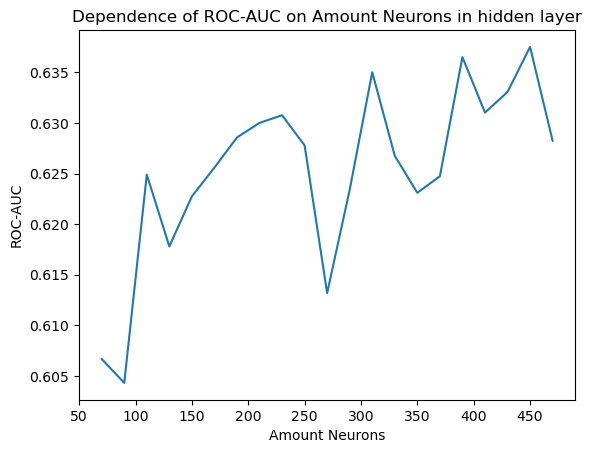

In [67]:
plt.plot(list_amount_neurons, list_roc_auc)
plt.xlabel('Amount Neurons')
plt.ylabel('ROC-AUC')
plt.title('Dependence of ROC-AUC on Amount Neurons in hidden layer')
plt.show();

In [68]:
mlp = MLPClassifier(hidden_layer_sizes=(110, 110), max_iter=1000, random_state=42)
mlp.fit(X_train_short, y_train_short)

roc_auc = roc_auc_score(y_test_short, mlp.predict_proba(X_test_short)[:, 1])
print(
    f'ROC-AUC test_set for MLPClassifier: {roc_auc}\n'
    f'Confusion_matrix test_set for MLPClassifier:\n {confusion_matrix(y_test_short, pred_mlp_test)}'
    )

ROC-AUC test_set for MLPClassifier: 0.5783681364284661
Confusion_matrix test_set for MLPClassifier:
 [[42384  1030]
 [ 1487    99]]


In [69]:
parameters_mlp = {
                  'hidden_layer_sizes': [(450,)],
                  'activation': ['logistic', 'relu'],
                  'solver': ['adam', 'lbfgs']
}

scores = ['f1', 'roc_auc']
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

list_params = []

for score in scores:
    grid = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), parameters_mlp, scoring=score, cv=cv, n_jobs=-2)
    grid.fit(X_train_short, y_train_short)
    
    list_params.append((score, grid.best_params_))
    print(score, grid.best_params_)

f1 {'activation': 'relu', 'hidden_layer_sizes': (450,), 'solver': 'lbfgs'}
roc_auc {'activation': 'logistic', 'hidden_layer_sizes': (450,), 'solver': 'lbfgs'}


In [70]:
# F1
mlp1 = MLPClassifier(hidden_layer_sizes=(450,), solver='lbfgs', activation='relu', max_iter=1000, random_state=42)
mlp1.fit(X_train_short, y_train_short)

pred_mlp_train1 = mlp1.predict(X_train_short)
pred_mlp_test1 = mlp1.predict(X_test_short)

print(
    f'ROC-AUC train_set for MLPClassifier: {roc_auc_score(y_train_short, mlp1.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test_set for MLPClassifier: {roc_auc_score(y_test_short, mlp1.predict_proba(X_test_short)[:, 1])}\n\n'
    f'Precision train_set for MLPClassifier: {precision_score(y_train_short, pred_mlp_train1)}\n'
    f'Precision test_set for MLPClassifier: {precision_score(y_test_short, pred_mlp_test1)}\n\n'
    f'Recall train_set for MLPClassifier: {recall_score(y_train_short, pred_mlp_train1)}\n'
    f'Recall test_set for MLPClassifier: {recall_score(y_test_short, pred_mlp_test1)}\n\n'
    f'Confusion_matrix test_set for MLPClassifier:\n {confusion_matrix(y_test_short, pred_mlp_test1)}'
    )

ROC-AUC train_set for MLPClassifier: 0.999597430386092
ROC-AUC test_set for MLPClassifier: 0.5967957280751113

Precision train_set for MLPClassifier: 0.9916036943744753
Precision test_set for MLPClassifier: 0.0854119425547997

Recall train_set for MLPClassifier: 0.939787798408488
Recall test_set for MLPClassifier: 0.06996904024767801

Confusion_matrix test_set for MLPClassifier:
 [[42175  1210]
 [ 1502   113]]


In [71]:
# ROC-AUC
mlp2 = MLPClassifier(hidden_layer_sizes=(450,), solver='lbfgs', activation='logistic', max_iter=1000, random_state=42)
mlp2.fit(X_train_short, y_train_short)

pred_mlp_train2 = mlp2.predict(X_train_short)
pred_mlp_test2 = mlp2.predict(X_test_short)

print(
    f'ROC-AUC train_set for MLPClassifier: {roc_auc_score(y_train_short, mlp2.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test_set for MLPClassifier: {roc_auc_score(y_test_short, mlp2.predict_proba(X_test_short)[:, 1])}\n\n'
    f'Precision train_set for MLPClassifier: {precision_score(y_train_short, pred_mlp_train2)}\n'
    f'Precision test_set for MLPClassifier: {precision_score(y_test_short, pred_mlp_test2)}\n\n'
    f'Recall train_set for MLPClassifier: {recall_score(y_train_short, pred_mlp_train2)}\n'
    f'Recall test_set for MLPClassifier: {recall_score(y_test_short, pred_mlp_test2)}\n\n'
    f'Confusion_matrix test_set for MLPClassifier:\n {confusion_matrix(y_test_short, pred_mlp_test2)}'
    )

ROC-AUC train_set for MLPClassifier: 0.7208926687159083
ROC-AUC test_set for MLPClassifier: 0.7077581421436907

Precision train_set for MLPClassifier: 0.22857142857142856
Precision test_set for MLPClassifier: 0.15384615384615385

Recall train_set for MLPClassifier: 0.002122015915119363
Recall test_set for MLPClassifier: 0.001238390092879257

Confusion_matrix test_set for MLPClassifier:
 [[43374    11]
 [ 1613     2]]


### 2.3.2. Best MLP classifier

In [75]:
mlp_best = MLPClassifier(hidden_layer_sizes=(450,), solver='lbfgs', activation='relu', max_iter=1000, random_state=42)
mlp_best.fit(X_train, y_train)

pred_mlp_best_train = mlp_best.predict(X_train)
pred_mlp_best_test = mlp_best.predict(X_test)

print(
    f'ROC-AUC train_set for MLPClassifier: {roc_auc_score(y_train, mlp_best.predict_proba(X_train)[:, 1])}\n'
    f'ROC-AUC test_set for MLPClassifier: {roc_auc_score(y_test, mlp_best.predict_proba(X_test)[:, 1])}\n\n'
    f'Precision train_set for MLPClassifier: {precision_score(y_train, pred_mlp_best_train)}\n'
    f'Precision test_set for MLPClassifier: {precision_score(y_test, pred_mlp_best_test)}\n\n'
    f'Recall train_set for MLPClassifier: {recall_score(y_train, pred_mlp_best_train)}\n'
    f'Recall test_set for MLPClassifier: {recall_score(y_test, pred_mlp_best_test)}\n\n'
    f'Confusion_matrix test_set for MLPClassifier:\n {confusion_matrix(y_test, pred_mlp_best_test)}'
    )

ROC-AUC train_set for MLPClassifier: 0.7908948121913789
ROC-AUC test_set for MLPClassifier: 0.7492846030360887

Precision train_set for MLPClassifier: 0.6277056277056277
Precision test_set for MLPClassifier: 0.38461538461538464

Recall train_set for MLPClassifier: 0.0051083918547572636
Recall test_set for MLPClassifier: 0.003288237504697482

Confusion_matrix test_set for MLPClassifier:
 [[578600    112]
 [ 21218     70]]


## 2.4. Cat Boost Classifier

In [76]:
cat_model = CatBoostClassifier(iterations=1000, eval_metric ='AUC', auto_class_weights='Balanced',
                               learning_rate=0.01, random_seed=42)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

pred_cat_model_train = cat_model.predict(X_train)
pred_cat_model_test = cat_model.predict(X_test)

print(
    f'ROC-AUC train_set for CatBoostClassifier: {roc_auc_score(y_train, cat_model.predict_proba(X_train)[:, 1])}\n'
    f'ROC-AUC test_set for CatBoostClassifier: {roc_auc_score(y_test, cat_model.predict_proba(X_test)[:, 1])}\n\n'
    f'Precision train_set for CatBoostClassifier: {precision_score(y_train, pred_cat_model_train)}\n'
    f'Precision test_set for CatBoostClassifier: {precision_score(y_test, pred_cat_model_test)}\n\n'
    f'Recall train_set for CatBoostClassifier: {recall_score(y_train, pred_cat_model_train)}\n'
    f'Recall test_set for CatBoostClassifier: {recall_score(y_test, pred_cat_model_test)}\n\n'
    f'Confusion_matrix test_set for CatBoostClassifier:\n {confusion_matrix(y_test, pred_cat_model_test)}'
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ROC-AUC train_set for CatBoostClassifier: 0.7534597694601646
ROC-AUC test_set for CatBoostClassifier: 0.7497831635820731

Precision train_set for CatBoostClassifier: 0.07227058082513335
Precision test_set for CatBoostClassifier: 0.0717400015264845

Recall train_set for CatBoostClassifier: 0.7101016980999131
Recall test_set for CatBoostClassifier: 0.7064543404735062

Confusion_matrix test_set for CatBoostClassifier:
 [[384119 194593]
 [  6249  15039]]


### 2.4.1. Hyperparameter Selection

**Reduce the dataset so that to speed up hyperparameter selection.**

In [77]:
cat_model = CatBoostClassifier(iterations=1000, eval_metric ='AUC', auto_class_weights='Balanced',
                               learning_rate=0.01, random_seed=42)

cat_model.fit(X_train_short, y_train_short, eval_set=(X_test_short, y_test_short), verbose=False, plot=True)

pred_cat_model_train = cat_model.predict(X_train_short)
pred_cat_model_test = cat_model.predict(X_test_short)

print(
    f'ROC-AUC train for CatBoostClassifier: {roc_auc_score(y_train_short, cat_model.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test for CatBoostClassifier: {roc_auc_score(y_test_short, cat_model.predict_proba(X_test_short)[:, 1])}\n\n'
    f'Precision train_set for CatBoostClassifier: {precision_score(y_train_short, pred_cat_model_train)}\n'
    f'Precision test_set for CatBoostClassifier: {precision_score(y_test_short, pred_cat_model_test)}\n\n'
    f'Recall train_set for CatBoostClassifier: {recall_score(y_train_short, pred_cat_model_train)}\n'
    f'Recall test_set for CatBoostClassifier: {recall_score(y_test_short, pred_cat_model_test)}\n\n'
    f'Confusion_matrix test_set for CatBoostClassifier:\n {confusion_matrix(y_test_short, pred_cat_model_test)}'
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ROC-AUC train for CatBoostClassifier: 0.7850580223987657
ROC-AUC test for CatBoostClassifier: 0.7317251793021727

Precision train_set for CatBoostClassifier: 0.08080601889653563
Precision test_set for CatBoostClassifier: 0.07073452469932731

Recall train_set for CatBoostClassifier: 0.7350132625994695
Recall test_set for CatBoostClassifier: 0.6445820433436532

Confusion_matrix test_set for CatBoostClassifier:
 [[29709 13676]
 [  574  1041]]


In [78]:
def objective(trial):
    params = {
              "objective": trial.suggest_categorical("objective", ["Logloss"]),
              "iterations": trial.suggest_int("iterations", 500, 1000),
              "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
              "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
              "depth": trial.suggest_int("depth", 4, 12),
              "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
              "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
              "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["Balanced", "SqrtBalanced"]),
              "verbose": False
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    
    cat_model = CatBoostClassifier(**params)
    cat_model.fit(X_train_short, y_train_short, eval_set=[(X_test_short, y_test_short)], verbose=False)

    return roc_auc_score(y_test_short, cat_model.predict_proba(X_test_short)[:, 1])


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-04-07 07:30:45,204] A new study created in memory with name: no-name-c612e08a-21fa-4cab-9478-ed175a371fc8
[I 2024-04-07 07:32:24,699] Trial 0 finished with value: 0.7055621512478633 and parameters: {'objective': 'Logloss', 'iterations': 667, 'learning_rate': 0.004088047188766204, 'colsample_bylevel': 0.09583205764974473, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'auto_class_weights': 'SqrtBalanced', 'bagging_temperature': 4.016027064671346}. Best is trial 0 with value: 0.7055621512478633.
[I 2024-04-07 07:34:00,353] Trial 1 finished with value: 0.6523181136851239 and parameters: {'objective': 'Logloss', 'iterations': 772, 'learning_rate': 0.0033493631667625345, 'colsample_bylevel': 0.03695659437707056, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'auto_class_weights': 'Balanced', 'bagging_temperature': 5.469118943617923}. Best is trial 0 with value: 0.7055621512478633.
[I 2024-04-07 07:36:34,540] Trial 2 finished with value: 0

[I 2024-04-07 07:56:03,463] Trial 20 finished with value: 0.7195760330056578 and parameters: {'objective': 'Logloss', 'iterations': 873, 'learning_rate': 0.0059536692954436045, 'colsample_bylevel': 0.08699082396625388, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'auto_class_weights': 'SqrtBalanced', 'subsample': 0.6370812094349827}. Best is trial 12 with value: 0.7350394177554197.
[I 2024-04-07 07:56:23,367] Trial 21 finished with value: 0.7338042817012771 and parameters: {'objective': 'Logloss', 'iterations': 924, 'learning_rate': 0.04554773149765551, 'colsample_bylevel': 0.06001399967276791, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'auto_class_weights': 'SqrtBalanced', 'subsample': 0.8388485100044174}. Best is trial 12 with value: 0.7350394177554197.
[I 2024-04-07 07:56:43,486] Trial 22 finished with value: 0.7332164424579268 and parameters: {'objective': 'Logloss', 'iterations': 920, 'learning_rate': 0.052869503804988276, 'colsamp

[I 2024-04-07 08:08:54,115] Trial 41 finished with value: 0.7292287107548477 and parameters: {'objective': 'Logloss', 'iterations': 928, 'learning_rate': 0.07740494645082573, 'colsample_bylevel': 0.05253838175758507, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'auto_class_weights': 'SqrtBalanced', 'subsample': 0.8420216746036443}. Best is trial 12 with value: 0.7350394177554197.
[I 2024-04-07 08:09:11,911] Trial 42 finished with value: 0.7334001386534488 and parameters: {'objective': 'Logloss', 'iterations': 964, 'learning_rate': 0.04811477978726596, 'colsample_bylevel': 0.04035135832124018, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'auto_class_weights': 'SqrtBalanced', 'subsample': 0.8441143556984673}. Best is trial 12 with value: 0.7350394177554197.
[I 2024-04-07 08:09:31,143] Trial 43 finished with value: 0.731660583778831 and parameters: {'objective': 'Logloss', 'iterations': 939, 'learning_rate': 0.06030194473221258, 'colsample_b

[I 2024-04-07 08:18:16,114] Trial 62 finished with value: 0.7324221501560476 and parameters: {'objective': 'Logloss', 'iterations': 978, 'learning_rate': 0.018028368963517578, 'colsample_bylevel': 0.03098621983710981, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'auto_class_weights': 'SqrtBalanced', 'subsample': 0.7838564829604274}. Best is trial 51 with value: 0.7350621532102769.
[I 2024-04-07 08:18:32,244] Trial 63 finished with value: 0.7338453353961275 and parameters: {'objective': 'Logloss', 'iterations': 957, 'learning_rate': 0.03629754241775261, 'colsample_bylevel': 0.03486845594216642, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'auto_class_weights': 'SqrtBalanced', 'subsample': 0.8793741830908532}. Best is trial 51 with value: 0.7350621532102769.
[I 2024-04-07 08:18:51,217] Trial 64 finished with value: 0.7303446319600123 and parameters: {'objective': 'Logloss', 'iterations': 983, 'learning_rate': 0.013811037603649245, 'colsampl

[I 2024-04-07 08:27:10,092] Trial 83 finished with value: 0.7347476603568524 and parameters: {'objective': 'Logloss', 'iterations': 811, 'learning_rate': 0.03592929706668658, 'colsample_bylevel': 0.07235186287940025, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'auto_class_weights': 'SqrtBalanced', 'subsample': 0.9039324659480216}. Best is trial 79 with value: 0.7353186656585808.
[I 2024-04-07 08:27:25,108] Trial 84 finished with value: 0.7297612527478252 and parameters: {'objective': 'Logloss', 'iterations': 810, 'learning_rate': 0.052417960719843185, 'colsample_bylevel': 0.07085451505449168, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'auto_class_weights': 'SqrtBalanced', 'subsample': 0.15742125019971437}. Best is trial 79 with value: 0.7353186656585808.
[I 2024-04-07 08:27:41,771] Trial 85 finished with value: 0.7314064904514301 and parameters: {'objective': 'Logloss', 'iterations': 778, 'learning_rate': 0.07017456842283602, 'colsampl

In [79]:
trial = study.best_trial
print(f'Best trial value:', trial.value)

print('Best Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial value: 0.7362361190450111
Best Params:
    objective: Logloss
    iterations: 716
    learning_rate: 0.03399818621006923
    colsample_bylevel: 0.07504240747734316
    depth: 5
    boosting_type: Plain
    bootstrap_type: Bernoulli
    auto_class_weights: SqrtBalanced
    subsample: 0.859444633361837


In [81]:
cat_model = CatBoostClassifier(objective='Logloss', iterations=1000, eval_metric ='AUC', auto_class_weights='SqrtBalanced',
                               learning_rate=0.034, colsample_bylevel=0.075, depth=5, boosting_type='Plain',
                               bootstrap_type='Bernoulli', subsample=0.859, random_seed=42)

cat_model.fit(X_train_short, y_train_short, eval_set=(X_test_short, y_test_short), verbose=False, plot=True)

pred_cat_model_train = cat_model.predict(X_train_short)
pred_cat_model_test = cat_model.predict(X_test_short)

print(
    f'ROC-AUC train for CatBoostClassifier: {roc_auc_score(y_train_short, cat_model.predict_proba(X_train_short)[:, 1])}\n'
    f'ROC-AUC test for CatBoostClassifier: {roc_auc_score(y_test_short, cat_model.predict_proba(X_test_short)[:, 1])}\n\n'
    f'Precision train_set for CatBoostClassifier: {precision_score(y_train_short, pred_cat_model_train)}\n'
    f'Precision test_set for CatBoostClassifier: {precision_score(y_test_short, pred_cat_model_test)}\n\n'
    f'Recall train_set for CatBoostClassifier: {recall_score(y_train_short, pred_cat_model_train)}\n'
    f'Recall test_set for CatBoostClassifier: {recall_score(y_test_short, pred_cat_model_test)}\n\n'
    f'Confusion_matrix test_set for CatBoostClassifier:\n {confusion_matrix(y_test_short, pred_cat_model_test)}'
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ROC-AUC train for CatBoostClassifier: 0.8157781266548771
ROC-AUC test for CatBoostClassifier: 0.7340018931940281

Precision train_set for CatBoostClassifier: 0.5012562814070352
Precision test_set for CatBoostClassifier: 0.21739130434782608

Recall train_set for CatBoostClassifier: 0.10583554376657825
Recall test_set for CatBoostClassifier: 0.04024767801857585

Confusion_matrix test_set for CatBoostClassifier:
 [[43151   234]
 [ 1550    65]]


### 2.4.2. Best Cat Boost Classifier

In [82]:
cat_model_best = CatBoostClassifier(objective='Logloss', iterations=5000, eval_metric ='AUC',
                                    auto_class_weights='Balanced',learning_rate=0.034, colsample_bylevel=0.075,
                                    depth=5, boosting_type='Plain', bootstrap_type='Bernoulli', subsample=0.859,
                                    random_seed=42)

cat_model_best.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

pred_cat_model_best_train = cat_model_best.predict(X_train)
pred_cat_model_best_test = cat_model_best.predict(X_test)

print(
    f'ROC-AUC train for CatBoostClassifier: {roc_auc_score(y_train, cat_model_best.predict_proba(X_train)[:, 1])}\n'
    f'ROC-AUC test for CatBoostClassifier: {roc_auc_score(y_test, cat_model_best.predict_proba(X_test)[:, 1])}\n\n'
    f'Precision train_set for CatBoostClassifier: {precision_score(y_train, pred_cat_model_best_train)}\n'
    f'Precision test_set for CatBoostClassifier: {precision_score(y_test, pred_cat_model_best_test)}\n\n'
    f'Recall train_set for CatBoostClassifier: {recall_score(y_train, pred_cat_model_best_train)}\n'
    f'Recall test_set for CatBoostClassifier: {recall_score(y_test, pred_cat_model_best_test)}\n\n'
    f'Confusion_matrix test_set for CatBoostClassifier:\n {confusion_matrix(y_test, pred_cat_model_best_test)}'
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ROC-AUC train for CatBoostClassifier: 0.7910349597297153
ROC-AUC test for CatBoostClassifier: 0.7630153156311499

Precision train_set for CatBoostClassifier: 0.08261872507504534
Precision test_set for CatBoostClassifier: 0.07714441451168251

Recall train_set for CatBoostClassifier: 0.7398360617234657
Recall test_set for CatBoostClassifier: 0.6914223975948891

Confusion_matrix test_set for CatBoostClassifier:
 [[402633 176079]
 [  6569  14719]]


## 2.5.Best Model

**The best model - CatBoostClassifier with ROC-AUC for the rest dataset = 0.762**

In [83]:
# save predicted flag for the test dataset
df_result_test = pd.DataFrame(data={'id': df_test['id'], 'flag_pred': pred_cat_model_best_test})
df_result_test.to_csv('df_result_test.csv', index=False)
df_result_test

,id,flag_pred
1679350,1679350,0
385353,385353,0
2137282,2137282,1
896053,896053,1
2824317,2824317,1
...,...,...
1567263,1567263,1
2359992,2359992,0
410308,410308,0
2452516,2452516,0


# 3. PipeLine

**Pack the resulting model into an automated PipeLine, which, when fit() is called, will prepare the data and train the model, and when predict() is called, will make predictions on a given data set**

In [84]:
class MyClassificationModel():
    def __init__(self):
        pass

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        numerical_features = X.columns
        numerical_transformer = MinMaxScaler()
        preprocessor = ColumnTransformer(transformers=[('numerical', numerical_transformer, numerical_features)])
        
        model = CatBoostClassifier(objective='Logloss', iterations=5000, eval_metric ='AUC',
                                   auto_class_weights='Balanced',learning_rate=0.034, colsample_bylevel=0.075,
                                   depth=5, boosting_type='Plain', bootstrap_type='Bernoulli', subsample=0.859,
                                   random_seed=42, verbose=False)

        self.pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        self.pipe.fit(X, y)

        return self

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        try:
            y_pred = self.pipe.predict(X)
        except AttributeError:
            print('!!!EROR!!! \n The Model did not fit. First you need to train the Model using the fit() method!')
            
            return self

        return y_pred

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        try:
            y_pred_prob = self.pipe.predict_proba(X)
        except AttributeError:
            print('!!!EROR!!! \n The Model did not fit. First you need to train the Model using the fit() method!')
            
            return self

        return y_pred_prob

# 4. Results

**We trained PipeLine on the entire dataset and saved the training result in binary format рiскlе.**

In [86]:
# using the full dataset for training the Model 
y = df_full['flag']
X = df_full.drop(columns=['flag', 'id'])

In [88]:
my_model = MyClassificationModel()
my_model.fit(X, y)

In [94]:
with open('./model.pkl', 'wb') as file:
    dill.dump({
        'model': my_model,
        'metadata': {
            'name': 'ML model for predicting the fact of default',
            'author': 'Aleksandr Ezerskiy',
            'version': 1.0,
            'date': datetime.datetime.now(),
            'type': type(my_model).__name__
        }
    }, file)